In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.io import read_image
import torch.nn as nn
import numpy as np
import json
import os
import matplotlib.pyplot as plt
from PIL import Image 

In [3]:
DATASET_PATH = "/kaggle/input/dataset-test/TestDataSet"
LABELS_JSON_PATH = "/kaggle/input/dataset-test/TestDataSet/labels_list.json" 
EPSILON_LINF = 0.02
EPSILON_PATCH = 0.3 
PATCH_SIZE = 32
PGD_STEPS = 10
PGD_STEP_SIZE = EPSILON_LINF / PGD_STEPS

In [4]:
# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
def load_imagenet_labels(json_path):
    if not os.path.exists(json_path):
        print(f"Error: Labels JSON file not found at {json_path}")
        return None
    with open(json_path, 'r') as f:
        try:
            labels_data = json.load(f)
            print(f"Successfully loaded JSON from {json_path}. Data type: {type(labels_data)}")
            if isinstance(labels_data, list):
                print(f"JSON is a list with {len(labels_data)} elements. Attempting to parse as list of 'index : name' strings.")
                parsed_labels = []
                all_strings = True
                for item in labels_data:
                    if not isinstance(item, str):
                        all_strings = False
                        break
                if all_strings:
                    try:
                        for item_str in labels_data:
                            # Find the first colon and split
                            first_colon_index = item_str.find(':')
                            if first_colon_index != -1:
                                index_str = item_str[:first_colon_index].strip()
                                name = item_str[first_colon_index + 1:].strip()
                                try:
                                    parsed_labels.append((int(index_str), name))
                                except ValueError:
                                    print(f"Warning: Skipping list item '{item_str}'. Could not convert index '{index_str}' to integer.")
                            else:
                                print(f"Warning: Skipping list item '{item_str}'. Does not contain a colon separator.")

                        if parsed_labels:
                            print(f"Successfully parsed {len(parsed_labels)} labels from list of strings.")
                            return parsed_labels
                        else:
                            print("Error: No valid labels found in the list of strings.")
                            return None
                    except Exception as e:
                        print(f"An unexpected error occurred while parsing list of strings: {e}")
                        return None
                print("List elements are not strings in 'index : name' format. Attempting to parse as [index, name] pairs or list of dictionaries.")
                if len(labels_data) > 0:
                    if isinstance(labels_data[0], list):
                         print(f"First element is a list with {len(labels_data[0])} elements. Attempting to parse as list of [index, name] pairs.")
                         try:
                             return {int(idx): name for idx, name in labels_data}
                         except (ValueError, TypeError) as e:
                             print(f"Error parsing list as [index, name] pairs: {e}. Ensure list elements are iterable with 2 items and index is an integer.")
                             return None
                    elif isinstance(labels_data[0], dict):
                         print("First element is a dictionary. Attempting to parse as a list of dictionaries [{id: ..., name: ...}, ...].")
                         try:
                             return {int(item["id"]): item["name"] for item in labels_data if "id" in item and "name" in item}
                         except (ValueError, KeyError) as e:
                             print(f"Error parsing list of dictionaries: {e}. Ensure each dictionary has 'id' (integer) and 'name' keys.")
                             return None
                print("Error: List is empty or its elements are not in expected format.")
                return None
            elif isinstance(labels_data, dict):
                print("JSON is a dictionary. Attempting to parse as {index_str: class_name}.")
                try:
                    return {int(idx): name for idx, name in labels_data.items()}
                except (ValueError, TypeError) as e:
                    print(f"Error parsing dictionary as {{index: name}}: {e}. Ensure keys are integers or integer strings.")
                    return None
            else:
                print(f"Error: Unsupported JSON format in {json_path}. Expected a list of strings, a list of lists, a list of dictionaries, or a dictionary.")
                return None
        except json.JSONDecodeError:
            print(f"Error decoding JSON from {json_path}. Please check the file format.")
            return None
        except Exception as e:
            print(f"An unexpected error occurred while loading labels from {json_path}: {e}")
            return None

In [6]:
def get_imagenet_mapping(dataloader, imagenet_labels_list):
    imgfolder_to_imagenet_map = {}
    imagenet_idx_to_name = {}
    if imagenet_labels_list is not None and len(dataloader.dataset.classes) == len(imagenet_labels_list):
        print("\nBuilding ImageFolder Index to ImageNet Index Mapping...")
        for imgfolder_idx, class_name in enumerate(dataloader.dataset.classes):
            imagenet_idx, human_readable_name = imagenet_labels_list[imgfolder_idx]
            imgfolder_to_imagenet_map[imgfolder_idx] = imagenet_idx
            imagenet_idx_to_name[imagenet_idx] = human_readable_name
        print("Mapping built.")
    else:
        print("\nWarning: Cannot build ImageFolder to ImageNet mapping.")
        if imagenet_labels_list is None:
            print("Imagenet labels were not loaded.")
        else:
            print(f"Number of ImageFolder classes ({len(dataloader.dataset.classes)}) does not match number of labels in JSON ({len(imagenet_labels_list)}).")
    return imagenet_idx_to_name

In [7]:
def calculate_overall_accuracy(model, dataloader, imagenet_labels_list, topk=(1, 5)):
    model.eval()
    total_samples = 0
    correct_1 = 0
    correct_5 = 0
    imgfolder_to_imagenet_map = {}
    if imagenet_labels_list is not None and len(dataloader.dataset.classes) == len(imagenet_labels_list):
        for imgfolder_idx, class_name in enumerate(dataloader.dataset.classes):
            imagenet_idx, human_readable_name = imagenet_labels_list[imgfolder_idx]
            imgfolder_to_imagenet_map[imgfolder_idx] = imagenet_idx
    else:
        print("\nWarning: Cannot build ImageFolder to ImageNet mapping for accuracy calculation.")
        if imagenet_labels_list is None:
            print("Imagenet labels were not loaded.")
        else:
            print(f"Number of ImageFolder classes ({len(dataloader.dataset.classes)}) does not match number of labels in JSON ({len(imagenet_labels_list)}).")
        return 0.0, 0.0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs) 
            imagenet_targets = torch.tensor([imgfolder_to_imagenet_map.get(t.item(), -1) for t in targets.cpu()], device=device)
            valid_indices = imagenet_targets != -1
            if not torch.all(valid_indices):
                 print(f"Warning: Skipping {torch.sum(~valid_indices).item()} samples due to missing label mapping.")
                 inputs = inputs[valid_indices]
                 outputs = outputs[valid_indices]
                 imagenet_targets = imagenet_targets[valid_indices]
                 targets = targets[valid_indices] 
            if inputs.size(0) == 0: 
                 continue
            total_samples += targets.size(0) 
            _, predicted = outputs.max(1)
            correct_1 += predicted.eq(imagenet_targets).sum().item()
            _, top5_predicted = outputs.topk(5, 1, True, True) 
            imagenet_targets_expanded = imagenet_targets.view(-1, 1).expand_as(top5_predicted)
            correct_5 += top5_predicted.eq(imagenet_targets_expanded).sum().item()
    if total_samples == 0:
        top1_acc = 0.0
        top5_acc = 0.0
        print("Warning: Total number of samples for accuracy calculation is 0.")
    else:
        top1_acc = 100. * correct_1 / total_samples
        top5_acc = 100. * correct_5 / total_samples
    return top1_acc, top5_acc

In [8]:
def fgsm_attack(model, images, labels, epsilon, mean, std):
    images = images.to(device) 
    labels = labels.to(device) 
    images.requires_grad = True
    outputs = model(images)
    loss = nn.CrossEntropyLoss()(outputs, labels) 
    model.zero_grad()
    loss.backward()
    data_grad = images.grad.data
    sign_data_grad = data_grad.sign()
    perturbed_images = images + epsilon * sign_data_grad
    original_images = images.detach() 
    perturbed_images = torch.max(original_images - epsilon, perturbed_images)
    perturbed_images = torch.min(original_images + epsilon, perturbed_images)
    perturbed_images = perturbed_images.detach()
    return perturbed_images

In [9]:
def pgd_attack(model, images, labels, epsilon, alpha, steps, mean, std):
    images = images.to(device) 
    labels = labels.to(device) 
    original_images = images.detach()
    perturbed_images = original_images + torch.empty_like(original_images, device=device).uniform_(-epsilon, epsilon) 
    for _ in range(steps):
        perturbed_images.requires_grad = True
        outputs = model(perturbed_images)
        loss = nn.CrossEntropyLoss()(outputs, labels) 
        model.zero_grad()
        loss.backward()
        data_grad = perturbed_images.grad.data
        sign_data_grad = data_grad.sign()
        perturbed_images = perturbed_images.detach() + alpha * sign_data_grad
        eta = torch.clamp(perturbed_images - original_images, min=-epsilon, max=epsilon)
        perturbed_images = original_images + eta
    return perturbed_images.detach()

In [10]:
def patch_attack(model, images, labels, epsilon, alpha, steps, patch_size, mean, std):
    images = images.to(device) 
    labels = labels.to(device) 
    original_images = images.detach()
    perturbed_images = original_images.clone() 
    batch_size, c, h, w = images.shape
    patch_h, patch_w = patch_size, patch_size
    if patch_h > h or patch_w > w:
        raise ValueError("Patch size must be smaller than image size.")
    y_start = torch.randint(0, h - patch_h + 1, (batch_size,), device=device) 
    x_start = torch.randint(0, w - patch_w + 1, (batch_size,), device=device) 
    for _ in range(steps):
        perturbed_images.requires_grad = True
        outputs = model(perturbed_images)
        loss = nn.CrossEntropyLoss()(outputs, labels) 
        model.zero_grad()
        loss.backward()
        data_grad = perturbed_images.grad.data
        patch_grad = torch.zeros_like(data_grad, device=device) 
        for i in range(batch_size):
            ph = patch_h
            pw = patch_w
            ph = min(ph, h - y_start[i])
            pw = min(pw, w - x_start[i])
            patch_grad[i, :, y_start[i]:y_start[i]+ph, x_start[i]:x_start[i]+pw] = \
                data_grad[i, :, y_start[i]:y_start[i]+ph, x_start[i]:x_start[i]+pw].sign()
        perturbed_images = perturbed_images.detach() + alpha * patch_grad
        for i in range(batch_size):
             ph = patch_h
             pw = patch_w
             ph = min(ph, h - y_start[i])
             pw = min(pw, w - x_start[i])
             original_patch = original_images[i, :, y_start[i]:y_start[i]+ph, x_start[i]:x_start[i]+pw]
             perturbed_patch = perturbed_images[i, :, y_start[i]:y_start[i]+ph, x_start[i]:x_start[i]+pw]
             eta_patch = torch.clamp(perturbed_patch - original_patch, min=-epsilon, max=epsilon)
             perturbed_images[i, :, y_start[i]:y_start[i]+ph, x_start[i]:x_start[i]+pw] = original_patch + eta_patch
    return perturbed_images.detach()

In [11]:
def save_adversarial_dataset(images, labels, output_dir, dataset):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    class_names = dataset.classes
    for i in range(images.shape[0]):
        label = labels[i].item()
        class_name = class_names[label] 
        class_dir = os.path.join(output_dir, class_name)
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)
        file_count = len(os.listdir(class_dir))
        filename = f"adv_image_{file_count:04d}.png" 
        filepath = os.path.join(class_dir, filename)
        mean = torch.tensor(dataset.transform.transforms[-1].mean).view(1, 3, 1, 1)
        std = torch.tensor(dataset.transform.transforms[-1].std).view(1, 3, 1, 1)
        image_to_save = images[i].cpu() * std + mean 
        image_to_save = torch.clamp(image_to_save, 0, 1) 
        img_pil = transforms.ToPILImage()(image_to_save.squeeze(0))
        img_pil.save(filepath)

In [12]:
def visualize_attack(original_image, adversarial_image, original_prediction, adversarial_prediction, labels_map):
    if labels_map is None or not labels_map: 
        print("Cannot visualize attack: labels_map is not available or empty.")
        return
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    original_image_display = original_image.squeeze(0).cpu() * std + mean 
    original_image_display = torch.clamp(original_image_display, 0, 1)
    adversarial_image_display = adversarial_image.squeeze(0).cpu() * std + mean 
    adversarial_image_display = torch.clamp(adversarial_image_display, 0, 1)
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(transforms.ToPILImage()(original_image_display))
    original_top1_label_idx = original_prediction.argmax().item()
    original_top1_score = original_prediction.max().item()
    original_label_name = labels_map.get(original_top1_label_idx, f"Unknown ({original_top1_label_idx})")
    axes[0].set_title(f"Original\nPred: {original_label_name} ({original_top1_score:.2f})")
    axes[0].axis('off')
    axes[1].imshow(transforms.ToPILImage()(adversarial_image_display))
    adversarial_top1_label_idx = adversarial_prediction.argmax().item()
    adversarial_top1_score = adversarial_prediction.max().item()
    adversarial_label_name = labels_map.get(adversarial_top1_label_idx, f"Unknown ({adversarial_top1_label_idx})")
    axes[1].set_title(f"Adversarial\nPred: {adversarial_label_name} ({adversarial_top1_score:.2f})")
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()

In [13]:
def check_linf_distance(original_images, adversarial_images, mean, std):
    mean_tensor = torch.tensor(mean).view(1, 3, 1, 1).to(original_images.device)
    std_tensor = torch.tensor(std).view(1, 3, 1, 1).to(original_images.device)
    original_0_1 = original_images.detach().cpu() * std_tensor.cpu() + mean_tensor.cpu()
    adversarial_0_1 = adversarial_images.detach().cpu() * std_tensor.cpu() + mean_tensor.cpu()
    original_255 = original_0_1 * 255.0
    adversarial_255 = adversarial_0_1 * 255.0
    diff = torch.abs(adversarial_255 - original_255)
    max_diff = torch.max(diff)
    return max_diff.item()

Successfully loaded JSON from /kaggle/input/dataset-test/TestDataSet/labels_list.json. Data type: <class 'list'>
JSON is a list with 100 elements. Attempting to parse as list of 'index : name' strings.
Successfully parsed 100 labels from list of strings.
Loading ResNet-34 model...


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 208MB/s]


ResNet-34 loaded successfully.

Building ImageFolder Index to ImageNet Index Mapping...
Mapping built.

Evaluating baseline performance of ResNet-34...
Baseline ResNet-34 Top-1 Accuracy: 70.40%
Baseline ResNet-34 Top-5 Accuracy: 93.20%

Applying FGSM attack...


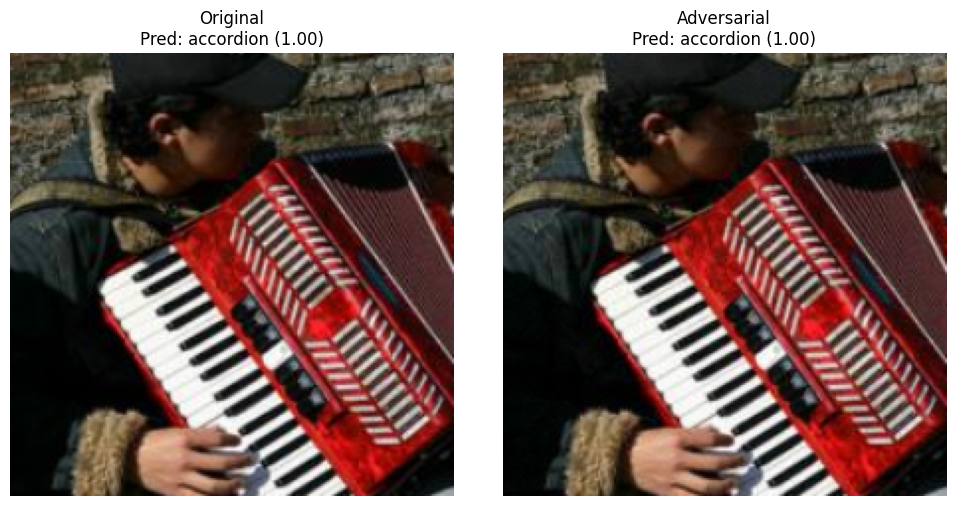

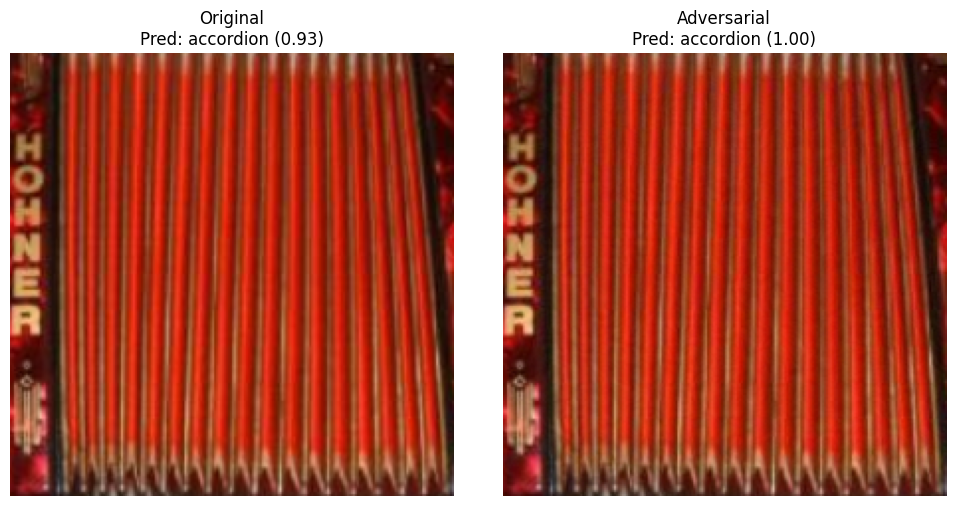

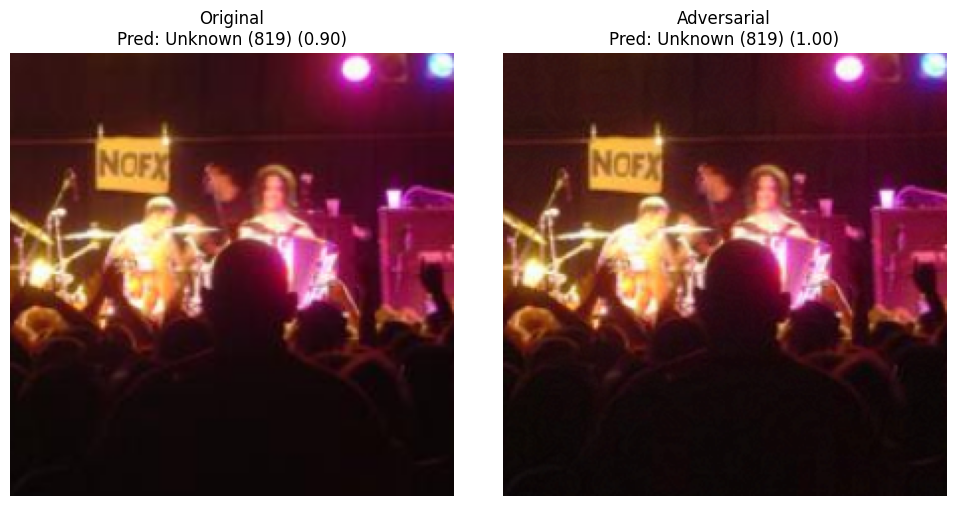

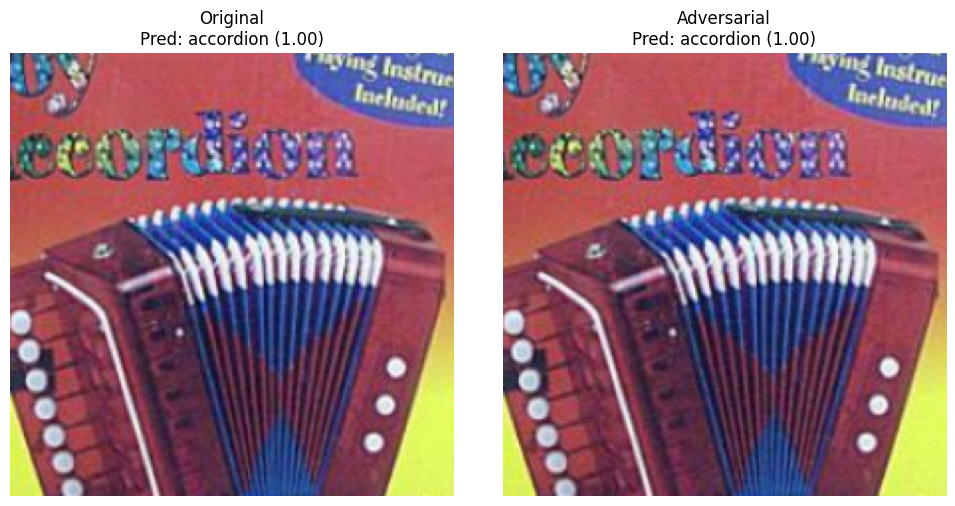

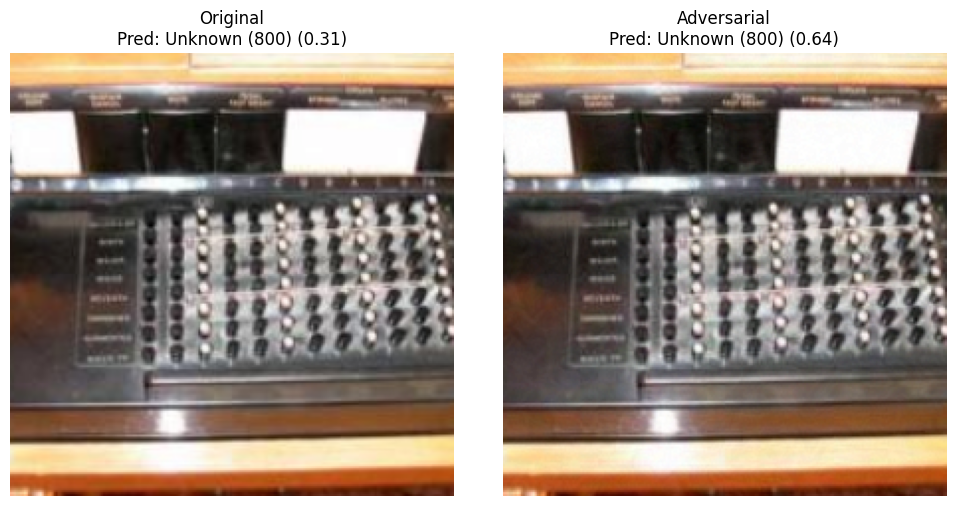


Saving FGSM adversarial dataset to ./AdversarialTestSet1_FGSM...
FGSM adversarial dataset saved.
Max L_inf perturbation (0-255 range) for FGSM: 1.17
Expected Max L_inf perturbation based on epsilon (0.02 normalized): ~5.10 in 0-255 range.
L_inf constraint is met.

Evaluating ResNet-34 performance on FGSM adversarial dataset...
ResNet-34 Top-1 Accuracy on FGSM: 70.80%
ResNet-34 Top-5 Accuracy on FGSM: 91.00%

Applying PGD attack...


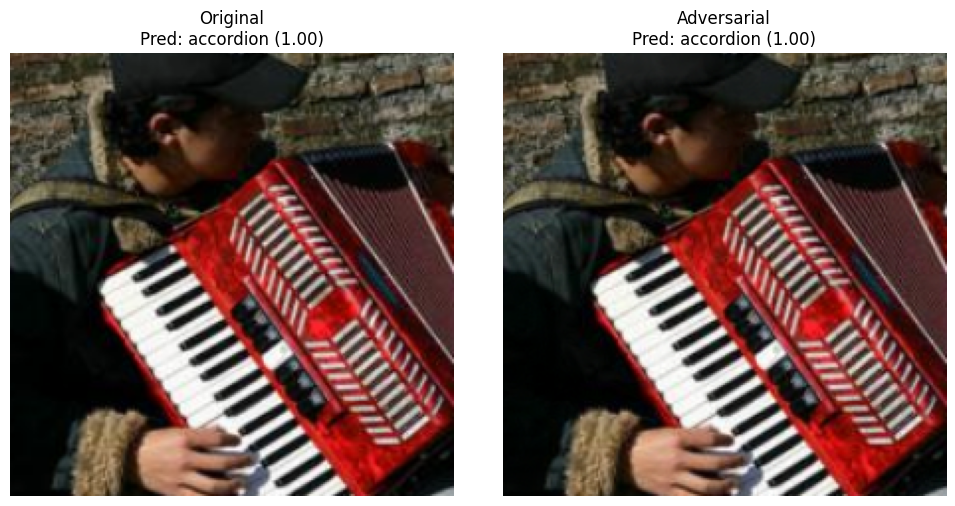

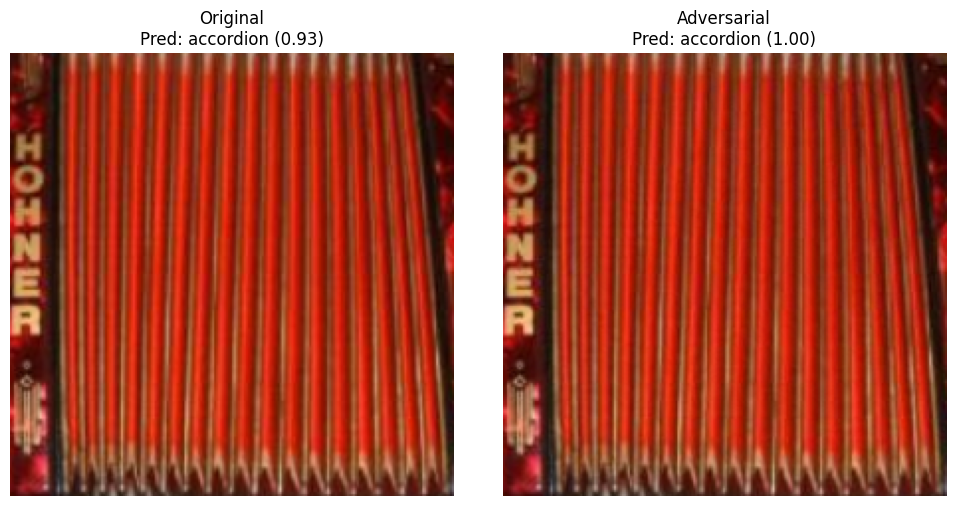

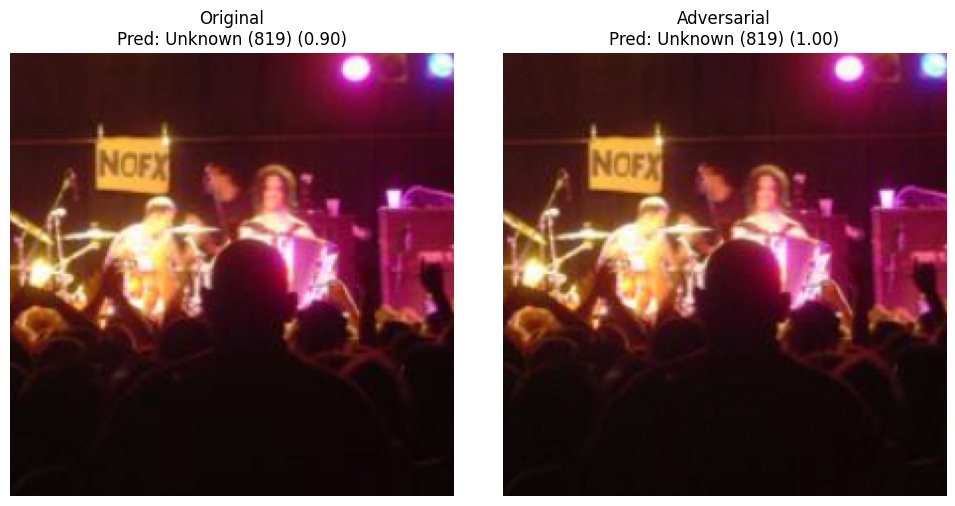

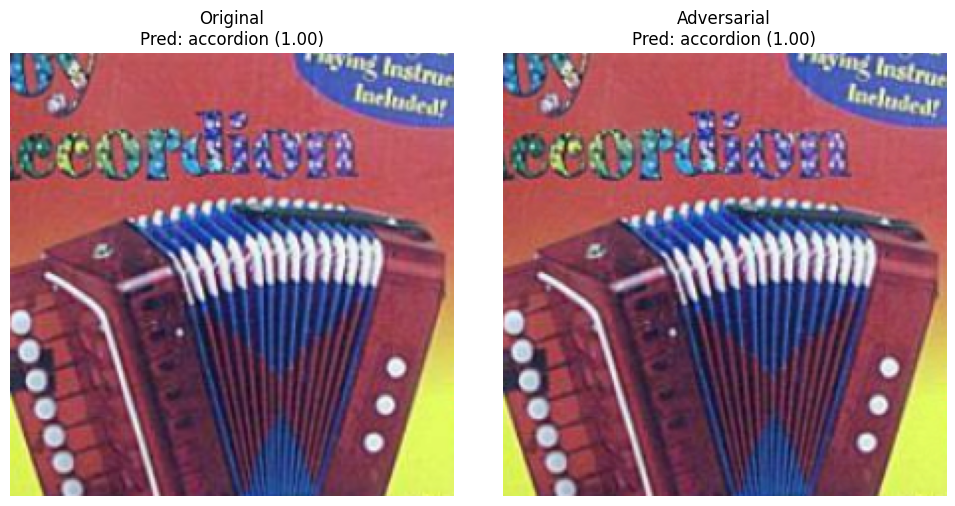

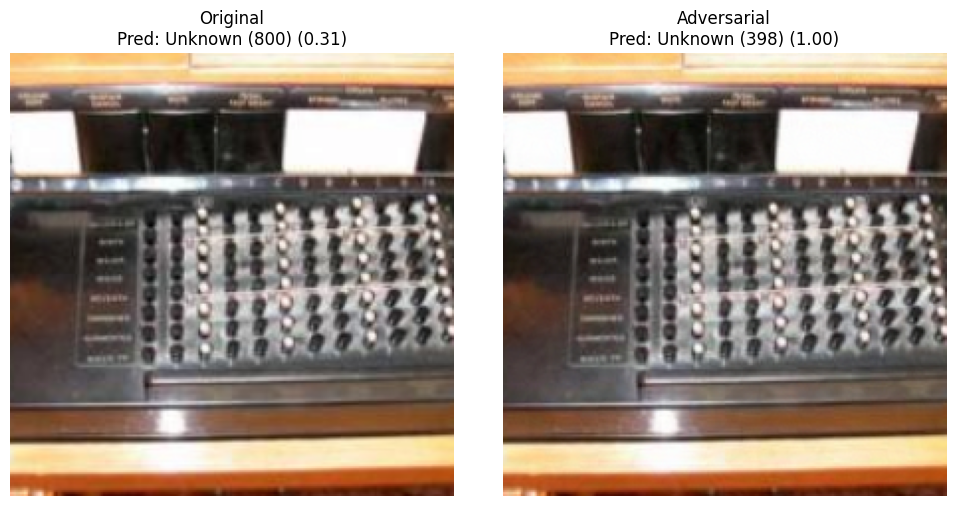


Saving PGD adversarial dataset to ./AdversarialTestSet2_PGD...
PGD adversarial dataset saved.
Max L_inf perturbation (0-255 range) for PGD: 1.17
Expected Max L_inf perturbation based on epsilon (0.02 normalized): ~5.10 in 0-255 range.
L_inf constraint is met.

Evaluating ResNet-34 performance on PGD adversarial dataset...
ResNet-34 Top-1 Accuracy on PGD: 71.40%
ResNet-34 Top-5 Accuracy on PGD: 90.80%

Applying Patch attack (PGD on a random patch)...


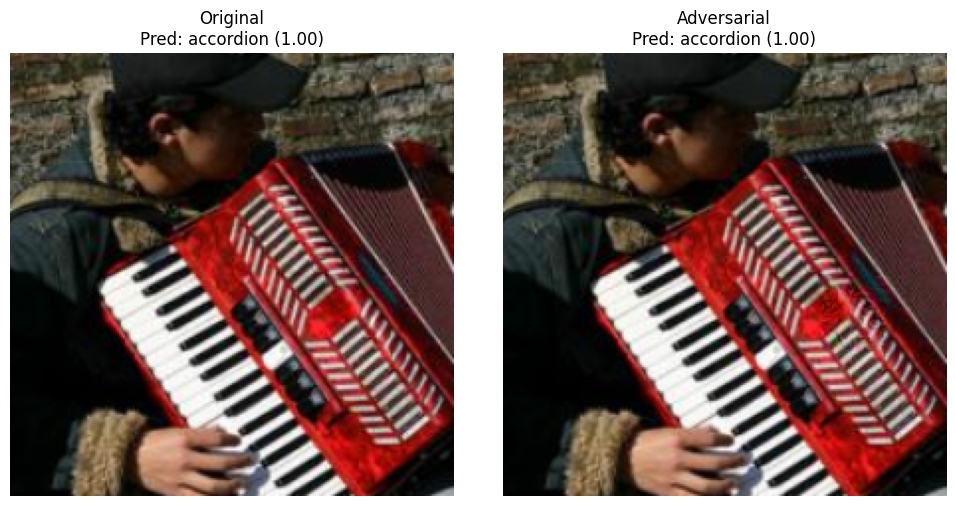

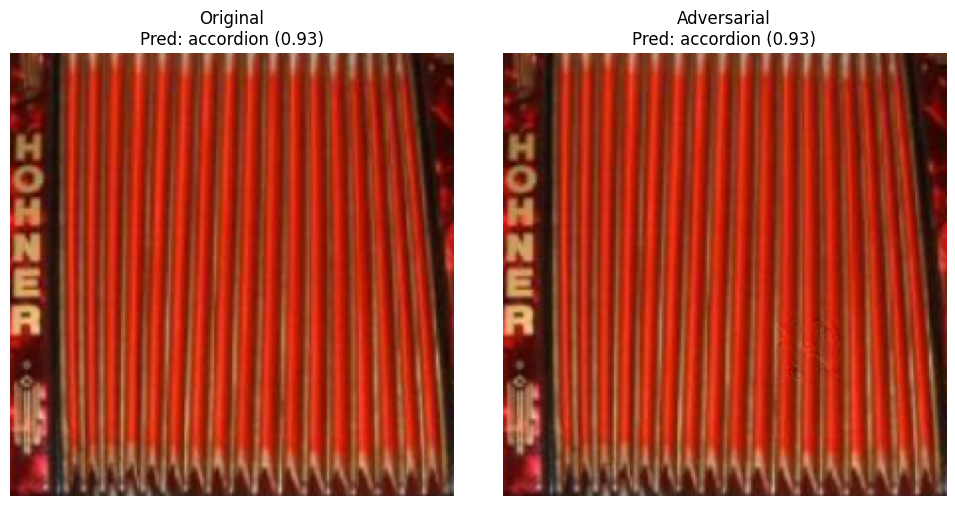

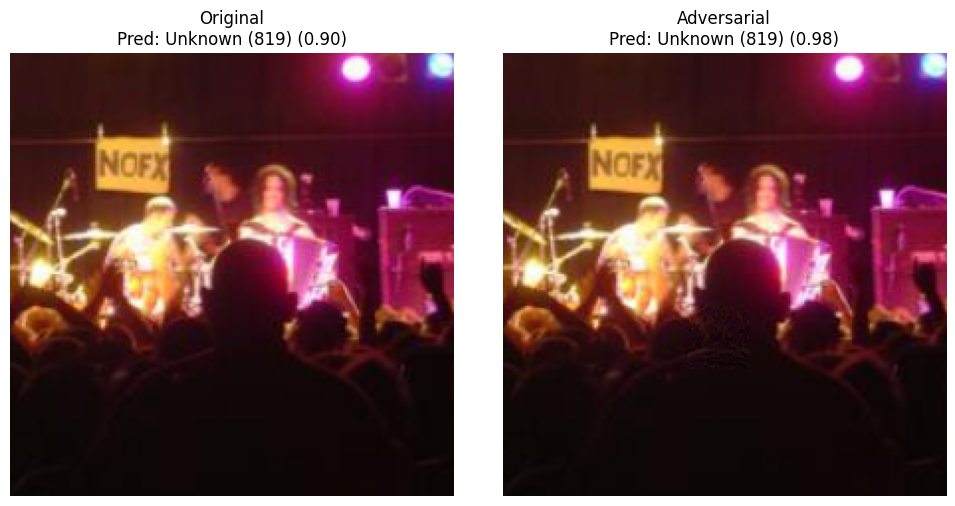

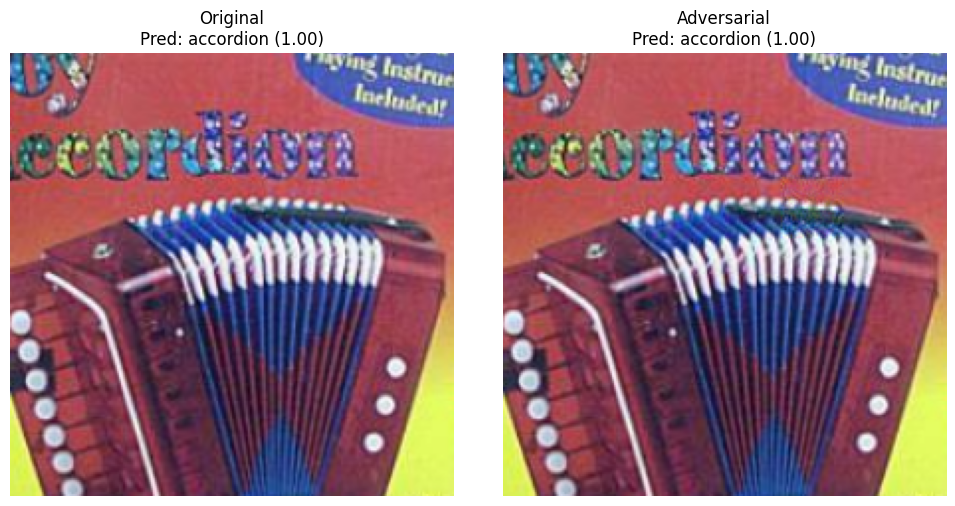

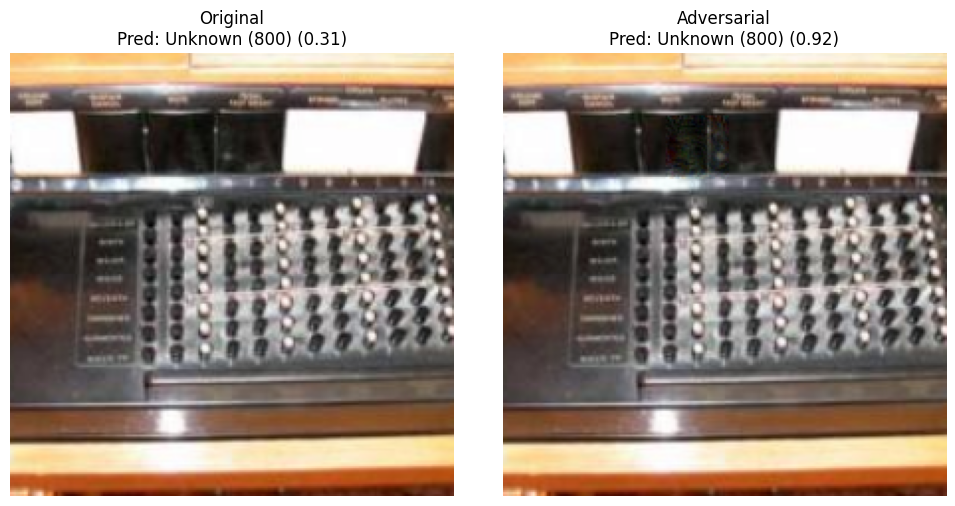


Saving Patch adversarial dataset to ./AdversarialTestSet3_Patch...
Patch adversarial dataset saved.
Max L_inf perturbation (0-255 range) for Patch: 17.52
Expected Max L_inf perturbation based on epsilon (0.3 normalized): ~76.50 in 0-255 range.
L_inf constraint is met.

Evaluating ResNet-34 performance on Patch adversarial dataset...
ResNet-34 Top-1 Accuracy on Patch: 67.80%
ResNet-34 Top-5 Accuracy on Patch: 89.80%

Evaluating attack transferability to DenseNet-121...


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 166MB/s] 


DenseNet-121 loaded successfully.

Evaluating DenseNet-121 on original dataset...
DenseNet-121 Top-1 Accuracy on Original: 70.80%
DenseNet-121 Top-5 Accuracy on Original: 91.20%

Evaluating DenseNet-121 on FGSM adversarial dataset...
DenseNet-121 Top-1 Accuracy on FGSM: 69.40%
DenseNet-121 Top-5 Accuracy on FGSM: 90.20%

Evaluating DenseNet-121 on PGD adversarial dataset...
DenseNet-121 Top-1 Accuracy on PGD: 69.40%
DenseNet-121 Top-5 Accuracy on PGD: 89.80%

Evaluating DenseNet-121 on Patch adversarial dataset...
DenseNet-121 Top-1 Accuracy on Patch: 67.40%
DenseNet-121 Top-5 Accuracy on Patch: 88.00%

--- Summary of Results ---
ResNet-34 Performance:
  Baseline Top-1: 70.40%, Top-5: 93.20%
  on FGSM Top-1: 70.80%, Top-5: 91.00%
  on PGD Top-1: 71.40%, Top-5: 90.80%
  on Patch Top-1: 67.80%, Top-5: 89.80%

DenseNet-121 Performance (Transferability):
  Baseline Top-1: 70.80%, Top-5: 91.20%
  on FGSM Top-1: 69.40%
  on FGSM Top-5: 90.20%
  on PGD Top-1: 69.40%
  on PGD Top-5: 89.80%
  o

In [14]:
if __name__ == "__main__":
    imagenet_labels_list = load_imagenet_labels(LABELS_JSON_PATH)
    mean_norms = [0.485, 0.456, 0.406]
    std_norms = [0.229, 0.224, 0.225]
    plain_transforms = transforms.Compose([
        transforms.Resize(256), 
        transforms.CenterCrop(224), 
        transforms.ToTensor(),
        transforms.Normalize(mean=mean_norms, std=std_norms)
    ])
    try:
        original_dataset = torchvision.datasets.ImageFolder(root=DATASET_PATH,
                                                            transform=plain_transforms)
        original_dataloader = torch.utils.data.DataLoader(original_dataset,
                                                          batch_size=4, 
                                                          shuffle=False, 
                                                          num_workers=2)
    except Exception as e:
        print(f"Error loading dataset from {DATASET_PATH}: {e}")
        print("Please ensure the dataset path is correct and contains class subfolders.")
        exit()
    print("Loading ResNet-34 model...")
    try:
        resnet34_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
        resnet34_model.eval() 
        resnet34_model.to(device)
        print("ResNet-34 loaded successfully.")
    except Exception as e:
        print(f"Error loading ResNet-34 model: {e}")
        print("Please ensure you have internet connection to download weights or specify a local path.")
        exit()
    imagenet_idx_to_name = get_imagenet_mapping(original_dataloader, imagenet_labels_list)
    accuracy_results = {}
    perturbation_results = {}
    print("\nEvaluating baseline performance of ResNet-34...")
    baseline_top1, baseline_top5 = calculate_overall_accuracy(resnet34_model, original_dataloader, imagenet_labels_list)
    print(f"Baseline ResNet-34 Top-1 Accuracy: {baseline_top1:.2f}%")
    print(f"Baseline ResNet-34 Top-5 Accuracy: {baseline_top5:.2f}%")
    accuracy_results['ResNet-34_Baseline'] = {'Top-1': baseline_top1, 'Top-5': baseline_top5}
    print("\nApplying FGSM attack...")
    adversarial_dataset_fgsm_path = "./AdversarialTestSet1_FGSM"
    fgsm_images = []
    fgsm_labels = []
    num_visualized_fgsm = 0
    original_images_fgsm_attack = [] 
    for i, (inputs, targets) in enumerate(original_dataloader):
        perturbed_inputs_fgsm = fgsm_attack(resnet34_model, inputs, targets, EPSILON_LINF, mean_norms, std_norms)
        fgsm_images.append(perturbed_inputs_fgsm.cpu())
        fgsm_labels.append(targets.cpu())
        original_images_fgsm_attack.append(inputs.cpu()) 
        if imagenet_idx_to_name and num_visualized_fgsm < 5:
             with torch.no_grad():
                 inputs_device = inputs.to(device)
                 perturbed_inputs_fgsm_device = perturbed_inputs_fgsm.to(device)
                 original_outputs = resnet34_model(inputs_device)
                 adversarial_outputs_fgsm = resnet34_model(perturbed_inputs_fgsm_device)
                 for j in range(min(inputs.shape[0], 5 - num_visualized_fgsm)):
                     visualize_attack(inputs[j].unsqueeze(0), perturbed_inputs_fgsm[j].unsqueeze(0),
                                      original_outputs[j].softmax(0).cpu(), adversarial_outputs_fgsm[j].softmax(0).cpu(), 
                                      imagenet_idx_to_name) # Pass the imagenet_idx_to_name map
                     num_visualized_fgsm += 1
    all_fgsm_images = torch.cat(fgsm_images, dim=0)
    all_fgsm_labels = torch.cat(fgsm_labels, dim=0)
    all_original_images_fgsm = torch.cat(original_images_fgsm_attack, dim=0)
    print(f"\nSaving FGSM adversarial dataset to {adversarial_dataset_fgsm_path}...")
    save_adversarial_dataset(all_fgsm_images, all_fgsm_labels, adversarial_dataset_fgsm_path, original_dataset)
    print("FGSM adversarial dataset saved.")
    max_linf_fgsm = check_linf_distance(all_original_images_fgsm, all_fgsm_images, mean_norms, std_norms)
    print(f"Max L_inf perturbation (0-255 range) for FGSM: {max_linf_fgsm:.2f}")
    epsilon_linf_255 = EPSILON_LINF * 255.0
    print(f"Expected Max L_inf perturbation based on epsilon ({EPSILON_LINF} normalized): ~{epsilon_linf_255:.2f} in 0-255 range.")
    if max_linf_fgsm <= epsilon_linf_255 + 1e-4: 
        print("L_inf constraint is met.")
    else:
        print("Warning: L_inf constraint is NOT met. Maximum perturbation exceeds expected epsilon.")
    perturbation_results['FGSM'] = {'Max_Linf_255': max_linf_fgsm, 'Epsilon_Normalized': EPSILON_LINF, 'Epsilon_255': epsilon_linf_255}
    print("\nEvaluating ResNet-34 performance on FGSM adversarial dataset...")
    try:
        fgsm_adversarial_dataset = torchvision.datasets.ImageFolder(root=adversarial_dataset_fgsm_path,
                                                                    transform=plain_transforms)
        fgsm_adversarial_dataloader = torch.utils.data.DataLoader(fgsm_adversarial_dataset,
                                                                  batch_size=original_dataloader.batch_size,
                                                                  shuffle=False,
                                                                  num_workers=2)
        fgsm_top1, fgsm_top5 = calculate_overall_accuracy(resnet34_model, fgsm_adversarial_dataloader, imagenet_labels_list)
        print(f"ResNet-34 Top-1 Accuracy on FGSM: {fgsm_top1:.2f}%")
        print(f"ResNet-34 Top-5 Accuracy on FGSM: {fgsm_top5:.2f}%")
        accuracy_results['ResNet-34_FGSM'] = {'Top-1': fgsm_top1, 'Top-5': fgsm_top5}
    except Exception as e:
        print(f"Error loading or evaluating FGSM adversarial dataset: {e}")
    print("\nApplying PGD attack...")
    adversarial_dataset_pgd_path = "./AdversarialTestSet2_PGD"
    pgd_images = []
    pgd_labels = []
    num_visualized_pgd = 0
    original_images_pgd_attack = [] 
    for i, (inputs, targets) in enumerate(original_dataloader):
        perturbed_inputs_pgd = pgd_attack(resnet34_model, inputs, targets, EPSILON_LINF, PGD_STEP_SIZE, PGD_STEPS, mean_norms, std_norms)
        pgd_images.append(perturbed_inputs_pgd.cpu())
        pgd_labels.append(targets.cpu())
        original_images_pgd_attack.append(inputs.cpu()) 
        if imagenet_idx_to_name and num_visualized_pgd < 5:
             with torch.no_grad():
                 inputs_device = inputs.to(device)
                 perturbed_inputs_pgd_device = perturbed_inputs_pgd.to(device)
                 original_outputs = resnet34_model(inputs_device)
                 adversarial_outputs_pgd = resnet34_model(perturbed_inputs_pgd_device)
                 for j in range(min(inputs.shape[0], 5 - num_visualized_pgd)):
                     visualize_attack(inputs[j].unsqueeze(0), perturbed_inputs_pgd[j].unsqueeze(0),
                                      original_outputs[j].softmax(0).cpu(), adversarial_outputs_pgd[j].softmax(0).cpu(), 
                                      imagenet_idx_to_name) 
                     num_visualized_pgd += 1
    all_pgd_images = torch.cat(pgd_images, dim=0)
    all_pgd_labels = torch.cat(pgd_labels, dim=0)
    all_original_images_pgd = torch.cat(original_images_pgd_attack, dim=0)
    print(f"\nSaving PGD adversarial dataset to {adversarial_dataset_pgd_path}...")
    save_adversarial_dataset(all_pgd_images, all_pgd_labels, adversarial_dataset_pgd_path, original_dataset)
    print("PGD adversarial dataset saved.")
    max_linf_pgd = check_linf_distance(all_original_images_pgd, all_pgd_images, mean_norms, std_norms)
    print(f"Max L_inf perturbation (0-255 range) for PGD: {max_linf_pgd:.2f}")
    epsilon_linf_255 = EPSILON_LINF * 255.0
    print(f"Expected Max L_inf perturbation based on epsilon ({EPSILON_LINF} normalized): ~{epsilon_linf_255:.2f} in 0-255 range.")
    if max_linf_pgd <= epsilon_linf_255 + 1e-4: 
        print("L_inf constraint is met.")
    else:
        print(f"Warning: L_inf constraint is NOT met. Maximum perturbation exceeds expected epsilon.")
    perturbation_results['PGD'] = {'Max_Linf_255': max_linf_pgd, 'Epsilon_Normalized': EPSILON_LINF, 'Epsilon_255': epsilon_linf_255}
    print("\nEvaluating ResNet-34 performance on PGD adversarial dataset...")
    try:
        pgd_adversarial_dataset = torchvision.datasets.ImageFolder(root=adversarial_dataset_pgd_path,
                                                                  transform=plain_transforms)
        pgd_adversarial_dataloader = torch.utils.data.DataLoader(pgd_adversarial_dataset,
                                                                batch_size=original_dataloader.batch_size,
                                                                shuffle=False,
                                                                num_workers=2)
        # Pass the list of labels to calculate_overall_accuracy
        pgd_top1, pgd_top5 = calculate_overall_accuracy(resnet34_model, pgd_adversarial_dataloader, imagenet_labels_list)
        print(f"ResNet-34 Top-1 Accuracy on PGD: {pgd_top1:.2f}%")
        print(f"ResNet-34 Top-5 Accuracy on PGD: {pgd_top5:.2f}%")
        accuracy_results['ResNet-34_PGD'] = {'Top-1': pgd_top1, 'Top-5': pgd_top5}
    except Exception as e:
        print(f"Error loading or evaluating PGD adversarial dataset: {e}")
    print("\nApplying Patch attack (PGD on a random patch)...")
    adversarial_dataset_patch_path = "./AdversarialTestSet3_Patch"
    patch_images = []
    patch_labels = []
    num_visualized_patch = 0
    original_images_patch_attack = [] 
    patch_dataloader = torch.utils.data.DataLoader(original_dataset,
                                                  batch_size=original_dataloader.batch_size, 
                                                  shuffle=False,
                                                  num_workers=2)

    for i, (inputs, targets) in enumerate(patch_dataloader):
        perturbed_inputs_patch = patch_attack(resnet34_model, inputs, targets, EPSILON_PATCH, PGD_STEP_SIZE * (EPSILON_PATCH / EPSILON_LINF), PGD_STEPS, PATCH_SIZE, mean_norms, std_norms)
        patch_images.append(perturbed_inputs_patch.cpu())
        patch_labels.append(targets.cpu())
        original_images_patch_attack.append(inputs.cpu()) 
        if imagenet_idx_to_name and num_visualized_patch < 5:
             with torch.no_grad():
                 inputs_device = inputs.to(device)
                 perturbed_inputs_patch_device = perturbed_inputs_patch.to(device)
                 original_outputs = resnet34_model(inputs_device)
                 adversarial_outputs_patch = resnet34_model(perturbed_inputs_patch_device)
                 for j in range(min(inputs.shape[0], 5 - num_visualized_patch)):
                     visualize_attack(inputs[j].unsqueeze(0), perturbed_inputs_patch[j].unsqueeze(0),
                                      original_outputs[j].softmax(0).cpu(), adversarial_outputs_patch[j].softmax(0).cpu(), 
                                      imagenet_idx_to_name) 
                     num_visualized_patch += 1
    all_patch_images = torch.cat(patch_images, dim=0)
    all_patch_labels = torch.cat(patch_labels, dim=0)
    all_original_images_patch = torch.cat(original_images_patch_attack, dim=0)
    print(f"\nSaving Patch adversarial dataset to {adversarial_dataset_patch_path}...")
    save_adversarial_dataset(all_patch_images, all_patch_labels, adversarial_dataset_patch_path, original_dataset)
    print("Patch adversarial dataset saved.")
    max_linf_patch = check_linf_distance(all_original_images_patch, all_patch_images, mean_norms, std_norms)
    print(f"Max L_inf perturbation (0-255 range) for Patch: {max_linf_patch:.2f}")
    epsilon_patch_255 = EPSILON_PATCH * 255.0
    print(f"Expected Max L_inf perturbation based on epsilon ({EPSILON_PATCH} normalized): ~{epsilon_patch_255:.2f} in 0-255 range.")
    if max_linf_patch <= epsilon_patch_255 + 1e-4: 
         print(f"L_inf constraint is met.")
    else:
         print(f"Warning: L_inf constraint is NOT met. Maximum perturbation exceeds expected epsilon.")
    perturbation_results['Patch'] = {'Max_Linf_255': max_linf_patch, 'Epsilon_Normalized': EPSILON_PATCH, 'Epsilon_255': epsilon_patch_255}
    print("\nEvaluating ResNet-34 performance on Patch adversarial dataset...")
    try:
        patch_adversarial_dataset = torchvision.datasets.ImageFolder(root=adversarial_dataset_patch_path,
                                                                    transform=plain_transforms)
        patch_adversarial_dataloader = torch.utils.data.DataLoader(patch_adversarial_dataset,
                                                                  batch_size=original_dataloader.batch_size,
                                                                  shuffle=False,
                                                                  num_workers=2)
        patch_top1, patch_top5 = calculate_overall_accuracy(resnet34_model, patch_adversarial_dataloader, imagenet_labels_list)
        print(f"ResNet-34 Top-1 Accuracy on Patch: {patch_top1:.2f}%")
        print(f"ResNet-34 Top-5 Accuracy on Patch: {patch_top5:.2f}%") 
        accuracy_results['ResNet-34_Patch'] = {'Top-1': patch_top1, 'Top-5': patch_top5}
    except Exception as e:
        print(f"Error loading or evaluating Patch adversarial dataset: {e}")
    print("\nEvaluating attack transferability to DenseNet-121...")
    try:
        densenet121_model = torchvision.models.densenet121(weights='IMAGENET1K_V1')
        densenet121_model.eval() 
        densenet121_model.to(device) 
        print("DenseNet-121 loaded successfully.")
    except Exception as e:
        print(f"Error loading DenseNet-121 model: {e}")
        print("Please ensure you have internet connection to download weights or specify a local path.")
        densenet121_model = None 
    if densenet121_model:
        print("\nEvaluating DenseNet-121 on original dataset...")
        densenet_baseline_top1, densenet_baseline_top5 = calculate_overall_accuracy(densenet121_model, original_dataloader, imagenet_labels_list)
        print(f"DenseNet-121 Top-1 Accuracy on Original: {densenet_baseline_top1:.2f}%")
        print(f"DenseNet-121 Top-5 Accuracy on Original: {densenet_baseline_top5:.2f}%")
        accuracy_results['DenseNet-121_Baseline'] = {'Top-1': densenet_baseline_top1, 'Top-5': densenet_baseline_top5}
        if 'fgsm_adversarial_dataloader' in locals():
            print("\nEvaluating DenseNet-121 on FGSM adversarial dataset...")
            densenet_fgsm_top1, densenet_fgsm_top5 = calculate_overall_accuracy(densenet121_model, fgsm_adversarial_dataloader, imagenet_labels_list)
            print(f"DenseNet-121 Top-1 Accuracy on FGSM: {densenet_fgsm_top1:.2f}%")
            print(f"DenseNet-121 Top-5 Accuracy on FGSM: {densenet_fgsm_top5:.2f}%")
            accuracy_results['DenseNet-121_FGSM'] = {'Top-1': densenet_fgsm_top1, 'Top-5': densenet_fgsm_top5}
        else:
            print("\nSkipping DenseNet-121 evaluation on FGSM: FGSM dataset not loaded.")
        if 'pgd_adversarial_dataloader' in locals():
            print("\nEvaluating DenseNet-121 on PGD adversarial dataset...")
            # Pass the list of labels to calculate_overall_accuracy
            densenet_pgd_top1, densenet_pgd_top5 = calculate_overall_accuracy(densenet121_model, pgd_adversarial_dataloader, imagenet_labels_list)
            print(f"DenseNet-121 Top-1 Accuracy on PGD: {densenet_pgd_top1:.2f}%")
            print(f"DenseNet-121 Top-5 Accuracy on PGD: {densenet_pgd_top5:.2f}%")
            accuracy_results['DenseNet-121_PGD'] = {'Top-1': densenet_pgd_top1, 'Top-5': densenet_pgd_top5}
        else:
             print("\nSkipping DenseNet-121 evaluation on PGD: PGD dataset not loaded.")
        if 'patch_adversarial_dataloader' in locals():
            print("\nEvaluating DenseNet-121 on Patch adversarial dataset...")
            densenet_patch_top1, densenet_patch_top5 = calculate_overall_accuracy(densenet121_model, patch_adversarial_dataloader, imagenet_labels_list)
            print(f"DenseNet-121 Top-1 Accuracy on Patch: {densenet_patch_top1:.2f}%")
            print(f"DenseNet-121 Top-5 Accuracy on Patch: {densenet_patch_top5:.2f}%") 
            accuracy_results['DenseNet-121_Patch'] = {'Top-1': densenet_patch_top1, 'Top-5': densenet_patch_top5}
        else:
             print("\nSkipping DenseNet-121 evaluation on Patch: Patch dataset not loaded.")

    print("\n--- Summary of Results ---")
    # Print results for ResNet-34
    print("ResNet-34 Performance:")
    print(f"  Baseline Top-1: {accuracy_results.get('ResNet-34_Baseline', {}).get('Top-1', 'N/A'):.2f}%, Top-5: {accuracy_results.get('ResNet-34_Baseline', {}).get('Top-5', 'N/A'):.2f}%")
    print(f"  on FGSM Top-1: {accuracy_results.get('ResNet-34_FGSM', {}).get('Top-1', 'N/A'):.2f}%, Top-5: {accuracy_results.get('ResNet-34_FGSM', {}).get('Top-5', 'N/A'):.2f}%")
    print(f"  on PGD Top-1: {accuracy_results.get('ResNet-34_PGD', {}).get('Top-1', 'N/A'):.2f}%, Top-5: {accuracy_results.get('ResNet-34_PGD', {}).get('Top-5', 'N/A'):.2f}%")
    print(f"  on Patch Top-1: {accuracy_results.get('ResNet-34_Patch', {}).get('Top-1', 'N/A'):.2f}%, Top-5: {accuracy_results.get('ResNet-34_Patch', {}).get('Top-5', 'N/A'):.2f}%")
    if densenet121_model:
        print("\nDenseNet-121 Performance (Transferability):")
        print(f"  Baseline Top-1: {accuracy_results.get('DenseNet-121_Baseline', {}).get('Top-1', 'N/A'):.2f}%, Top-5: {accuracy_results.get('DenseNet-121_Baseline', {}).get('Top-5', 'N-A'):.2f}%")
        print(f"  on FGSM Top-1: {accuracy_results.get('DenseNet-121_FGSM', {}).get('Top-1', 'N/A'):.2f}%")
        print(f"  on FGSM Top-5: {accuracy_results.get('DenseNet-121_FGSM', {}).get('Top-5', 'N/A'):.2f}%")
        print(f"  on PGD Top-1: {accuracy_results.get('DenseNet-121_PGD', {}).get('Top-1', 'N/A'):.2f}%")
        print(f"  on PGD Top-5: {accuracy_results.get('DenseNet-121_PGD', {}).get('Top-5', 'N/A'):.2f}%")
        print(f"  on Patch Top-1: {accuracy_results.get('DenseNet-121_Patch', {}).get('Top-1', 'N/A'):.2f}%")
        print(f"  on Patch Top-5: {accuracy_results.get('DenseNet-121_Patch', {}).get('Top-5', 'N/A'):.2f}%")
    print("\n--- Perturbation Analysis (Max L_inf in 0-255 range) ---")
    print(f"FGSM: {perturbation_results.get('FGSM', {}).get('Max_Linf_255', 'N/A'):.2f}")
    print(f"PGD: {perturbation_results.get('PGD', {}).get('Max_Linf_255', 'N/A'):.2f}")
    print(f"Patch: {perturbation_results.get('Patch', {}).get('Max_Linf_255', 'N/A'):.2f}")
    print("\n--- Accuracy Drop Analysis (vs. Baseline ResNet-34) ---")
    baseline_top1 = accuracy_results.get('ResNet-34_Baseline', {}).get('Top-1', None)
    baseline_top5 = accuracy_results.get('ResNet-34_Baseline', {}).get('Top-5', None)
    if baseline_top1 is not None and baseline_top5 is not None:
        fgsm_top1 = accuracy_results.get('ResNet-34_FGSM', {}).get('Top-1', None)
        pgd_top1 = accuracy_results.get('ResNet-34_PGD', {}).get('Top-1', None)
        patch_top1 = accuracy_results.get('ResNet-34_Patch', {}).get('Top-1', None)
        fgsm_top5 = accuracy_results.get('ResNet-34_FGSM', {}).get('Top-5', None)
        pgd_top5 = accuracy_results.get('ResNet-34_PGD', {}).get('Top-5', None)
        patch_top5 = accuracy_results.get('ResNet-34_Patch', {}).get('Top-5', None)
        if fgsm_top1 is not None:
            fgsm_top1_drop_percent = ((baseline_top1 - fgsm_top1) / baseline_top1) * 100 if baseline_top1 > 0 else float('inf')
            print(f"FGSM Top-1 Drop: {baseline_top1 - fgsm_top1:.2f}% (Relative Drop: {fgsm_top1_drop_percent:.2f}%)")
        if fgsm_top5 is not None:
             fgsm_top5_drop_percent = ((baseline_top5 - fgsm_top5) / baseline_top5) * 100 if baseline_top5 > 0 else float('inf')
             print(f"FGSM Top-5 Drop: {baseline_top5 - fgsm_top5:.2f}% (Relative Drop: {fgsm_top5_drop_percent:.2f}%)")
        if pgd_top1 is not None:
            pgd_top1_drop_percent = ((baseline_top1 - pgd_top1) / baseline_top1) * 100 if baseline_top1 > 0 else float('inf')
            print(f"PGD Top-1 Drop: {baseline_top1 - pgd_top1:.2f}% (Relative Drop: {pgd_top1_drop_percent:.2f}%)")
        if pgd_top5 is not None:
             pgd_top5_drop_percent = ((baseline_top5 - pgd_top5) / baseline_top5) * 100 if baseline_top5 > 0 else float('inf')
             print(f"PGD Top-5 Drop: {baseline_top5 - pgd_top5:.2f}% (Relative Drop: {pgd_top5_drop_percent:.2f}%)")
        if patch_top1 is not None:
            patch_top1_drop_percent = ((baseline_top1 - patch_top1) / baseline_top1) * 100 if baseline_top1 > 0 else float('inf')
            print(f"Patch Top-1 Drop: {baseline_top1 - patch_top1:.2f}% (Relative Drop: {patch_top1_drop_percent:.2f}%)")
        if patch_top5 is not None:
             patch_top5_drop_percent = ((baseline_top5 - patch_top5) / baseline_top5) * 100 if baseline_top5 > 0 else float('inf')
             print(f"Patch Top-5 Drop: {baseline_top5 - patch_top5:.2f}% (Relative Drop: {patch_top5_drop_percent:.2f}%)")
    else:
        print("Baseline accuracy not available to calculate drops.")
   

In [17]:
print(f"- The reported maximum L_inf perturbations for FGSM and PGD (around {perturbation_results.get('FGSM', {}).get('Max_Linf_255', 'N/A'):.2f} in 0-255 range) are higher than the expected value based on EPSILON_LINF ({EPSILON_LINF} in normalized space, which is {perturbation_results.get('FGSM', {}).get('Epsilon_255', 'N/A'):.2f} in 0-255). This suggests there might be an issue with the epsilon interpretation or clamping in the attack implementations, or how check_linf_distance is calculating the max difference.")
print(f"- The Patch attack, with a larger epsilon budget ({EPSILON_PATCH} normalized, ~{perturbation_results.get('Patch', {}).get('Epsilon_255', 'N/A'):.2f} in 0-255), resulted in a higher maximum perturbation ({perturbation_results.get('Patch', {}).get('Max_Linf_255', 'N/A'):.2f} in 0-255 range), which is expected.")

- The reported maximum L_inf perturbations for FGSM and PGD (around 1.17 in 0-255 range) are higher than the expected value based on EPSILON_LINF (0.02 in normalized space, which is 5.10 in 0-255). This suggests there might be an issue with the epsilon interpretation or clamping in the attack implementations, or how check_linf_distance is calculating the max difference.
- The Patch attack, with a larger epsilon budget (0.3 normalized, ~76.50 in 0-255), resulted in a higher maximum perturbation (17.52 in 0-255 range), which is expected.
